In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
train_df = pd.read_csv('train.csv')
"basic view of raw dataset"
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
# import pandas_profiling
# profile = pandas_profiling.ProfileReport(train_df)
# profile.to_file(output_file="./reportb.html")
# # # a copy of the profile report is saved in the main directory
# # pandas_profiling.ProfileReport(train_df)

In [4]:
"""Now defining classes necessary for preprocessing"""

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.discretisers import EqualFrequencyDiscretiser as efd
from feature_engine.discretisers import DecisionTreeDiscretiser as dtd

# global variables are declared here for encoding the test data set based on the target variable
global dtd_g
global efd_g
efd_g = efd(q=8, variables = ['Age','Fare'])
dtd_g = dtd(cv=5, scoring='accuracy', variables = ['Age','Fare'],
            regression=False, param_grid = {'max_depth':[3,4,5,6]})

class mean_encoder(BaseEstimator, TransformerMixin):
    """A very common feautre engineering for improving quality of binary classification"""
    
    def __init__(self, target_col = None, column_array=[], encoder = []):
        self.target_col = target_col
        self.mean_encodings = encoder
        self.column_array = column_array
        
    def fit(self, df):
        if self.mean_encodings != []:
            return self
        for i in self.column_array:
            self.mean_encodings.append(df.groupby([i])[self.target_col].mean().to_dict())   
        # for test set pipelining
        global encoding_g
        encoding_g = self.mean_encodings
        return self
    
    def transform(self, df):
        for encodings,column in zip(self.mean_encodings,self.column_array):
            df[column+'_mean_enc'] = df[column].apply(lambda value: encodings[value])
        return df

class Drop_Col(BaseEstimator, TransformerMixin):
    
    """For dropping unnecessary columns"""
    
    def __init__(self,column_array=[]):
        self.column_array = column_array
        
    def fit(self, df, y = None):
        return self
    
    def transform(self, df):
        return df.drop(self.column_array, axis = 1)

class custom_pr(BaseEstimator, TransformerMixin):
    
    """For extracting useful info from the Cabin column of the dataset,
    dropping null values for age, imputing fare values and for other custom transformations"""
    
    def __init__(self,drop_=True):
        self.drop_ = drop_

    def fit(self, df, y = None):
        return self
    
    def transform(self, df):
        df.Cabin.fillna('Z', inplace = True)
        df['Cabin'] = df['Cabin'].apply(lambda x: str(str(x)[0]))
        if self.drop_==True:
            df.dropna(inplace= True, subset = ['Age'])
        else:
            df.Age.fillna(df.Age.median(), inplace=True)
        df.Fare.fillna(df.Fare.median(), inplace=True)
        return df
    
class One_Hot_Encoder(BaseEstimator, TransformerMixin):
    """For One Hot Encoding categorical variables"""
    
    def __init__(self,column_array=[]):
        self.column_array = column_array
    
    def fit(self, df):
        return self
    
    def transform(self,df):
        for i in self.column_array:
            df[i+'i'] = df[i]
        return pd.get_dummies(df, columns = self.column_array, drop_first=True)
        
class cv_discretizer(BaseEstimator, TransformerMixin):
    """ For discretizing continuous variables for extracting useful features"""
    
    def __init__(self,column_array=[],use_global=False):
        self.column_array = column_array
        self.use_global = use_global
    
    def fit(self,df):
        self.efd_ = efd(q=8, variables = self.column_array)
        self.dtd_ = dtd(cv=5, scoring='accuracy', variables = self.column_array,
                   regression=False, param_grid = {'max_depth':[3,4,5,6]})
        if self.use_global==False:
            self.dtd_.fit(df,df.Survived)
            self.efd_.fit(df,df.Survived)
            dtd_g.fit(df,df.Survived)
            efd_g.fit(df,df.Survived)
        return self
        
    def transform(self,df,y=None):
        lf = df.copy()
        for i in self.column_array:
            if self.use_global == False:
                lf[i+str('ef')] = self.efd_.transform(df)[i]
                lf[i+str('dt')] = self.dtd_.transform(df)[i]
            else:
                df['Survived'] = pd.Series([0 for i in range(df.shape[0])]) # dummy column
                lf[i+str('ef')] = efd_g.transform(df)[i]
                lf[i+str('dt')] = dtd_g.transform(df)[i]
        df = df.drop(df.index)
        return lf

# we drop the below columns as they are random and have no useful information. 'Cabin' has high correlation
# with 'PClass' and 'Sex' is dropped as its target encoding has more feature importance.

pre_pipe = Pipeline([("custom_pr",custom_pr()),
                     ("mean_encoder", mean_encoder('Survived',['Sex'])),
                     ("dropcol", Drop_Col(['Ticket','Name','PassengerId','Embarked','Cabin','Sex'])),
                     ('cv_discretizer', cv_discretizer(['Age','Fare']))
                    ])

train_df = pre_pipe.fit_transform(train_df).astype('float32')
train_df

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_mean_enc,Ageef,Agedt,Fareef,Faredt
0,0.0,3.0,22.0,1.0,0.0,7.250000,0.205298,2.0,0.356618,0.0,0.212560
1,1.0,1.0,38.0,1.0,0.0,71.283302,0.754789,5.0,0.413158,6.0,0.628571
2,1.0,3.0,26.0,0.0,0.0,7.925000,0.754789,3.0,0.356618,1.0,0.212560
3,1.0,1.0,35.0,1.0,0.0,53.099998,0.754789,5.0,0.413158,6.0,0.750000
4,0.0,3.0,35.0,0.0,0.0,8.050000,0.205298,5.0,0.413158,1.0,0.212560
...,...,...,...,...,...,...,...,...,...,...,...
885,0.0,3.0,39.0,0.0,5.0,29.125000,0.754789,6.0,0.413158,5.0,0.437299
886,0.0,2.0,27.0,0.0,0.0,13.000000,0.205298,3.0,0.413158,3.0,0.437299
887,1.0,1.0,19.0,0.0,0.0,30.000000,0.754789,1.0,0.356618,5.0,0.437299
889,1.0,1.0,26.0,0.0,0.0,30.000000,0.205298,3.0,0.356618,5.0,0.437299


In [5]:
"""According to the profile report we have several outliers. They will be removed accordingly, based on
their effect on model performane"""
train_df.drop(train_df[train_df.Age<1].index,inplace=True)

In [6]:
"""Splitting data into train and test set"""
from sklearn.model_selection import train_test_split

X = train_df.drop(['Survived'],1).to_numpy()
y = train_df['Survived'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.18, random_state = 42)

In [7]:
"""In this notebook, we use xgboost's random forest classifier"""
from xgboost import XGBRFClassifier

# defining fixed params
verbosity = 3
objective = 'binary:logistic'
n_jobs = 4
folds = 6

# defining a set of hyperparams for grid search
params = {'n_estimators' : [200, 300, 400, 500, 600],
          'max_depth' : [5, 7, 9 ,11, 12, 14, 16, 18],
          'min_child_weight' : [0.5, 0.1, 1, 5, 10],
          'reg_alpha' : [1, 10, 50, 100],
          'reg_lambda' : [1, 10, 50, 100]
         }

# for runtime evaluation:
eval_set = [(X_train[i], y_train[i]) for i in np.random.choice(X_train.shape[0], X_train.shape[0]//6)]

In [8]:
"""For hyperparameter tuning, we use sklearn's Grid Search CV to find the best parameters"""
# Since this process takes up a lot of time, you can skip to the next cell by commenting this code

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

xgb = XGBRFClassifier(objective=objective, nthread=1, silent= True,
                      eval_set=eval_set, eval_metric = 'auc', early_stopping_rounds = 50)

random_search = GridSearchCV(xgb, param_grid=params,
                             scoring='accuracy', n_jobs=n_jobs,
                             cv=skf.split(X,y), verbose = verbosity)
random_search.fit(X,y)
random_search.best_params_

In [9]:
"""Training Final Model""" # based on best params
xgbf = XGBRFClassifier(objective=objective, nthread=1, silent= True,
                       learning_rate = 0.001,
                       max_depth = 11,
                       min_child_weight=0.5,
                       n_estimators = 500,
                       reg_alpha = 1,
                       reg_lambda = 1,
                       eval_set=eval_set,
                       eval_metric = 'auc',
                       early_stopping_rounds = 50)
xgbf.fit(X,y)

[23:07:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds, eval_set, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, early_stopping_rounds=50, eval_metric='auc',
                eval_set=[(array([ 3.        , 30.        ,  1.        ,  1.        , 24.15      ,
        0.7547893 ,  4.        ,  0.41315788,  4.        ,  0.43729904],
      dtype=float32),
                           0.0),
                          (array([ 3.        , 30.        ,  0.        ,  0.        ,  8.6625    ,
        0.7547893 ,  4.        ,  0.41315788,  2.        ,  0.21256039],
      dtype=float32),
                           0.0),
                          (array([ 1.        , 25.        ,  1.        ,  0.        , 55.4417    ,
        0.205298...
                interaction_constraints='', learning_rate=0.001,
                max_delta_step=0, max_depth=11, min_child_weight=0.5,
                missing=nan, monotone_constraints='()', n_estimators=500,
                n_jobs=1, nthread=1, num_parallel_tree=500,
      

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

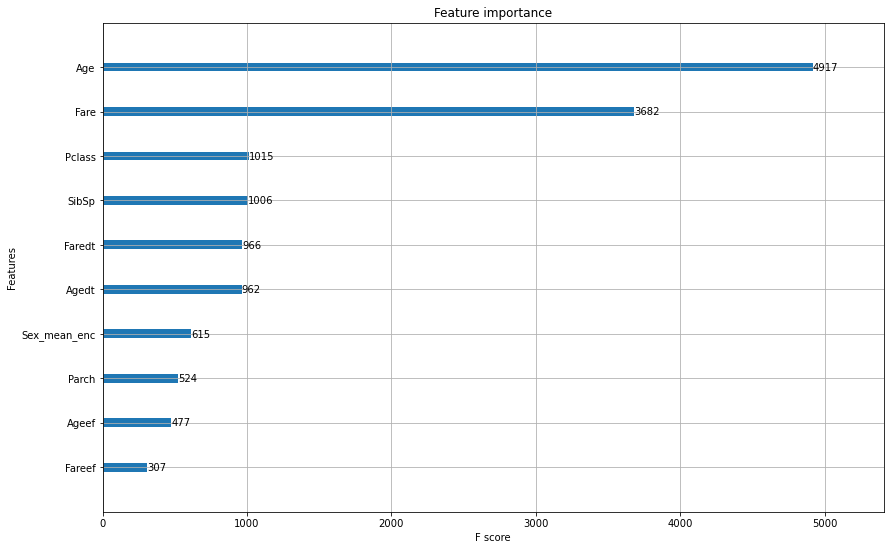

In [10]:
from xgboost import plot_importance
"""Plotting Feature Importance"""
og_names = xgbf.get_booster().feature_names 
xgbf.get_booster().feature_names = train_df.drop('Survived',1).columns.tolist()
fig, ax = plt.subplots(1,1,figsize=(14,9))
plot_importance(xgbf,ax=ax)

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
"""Accuracy Score and Classification report"""

xgbf.get_booster().feature_names = og_names
y_pred = xgbf.predict(X_test)
print('Accuracy = {}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=['Not Survived','Survived']))

Accuracy = 0.9140625
              precision    recall  f1-score   support

Not Survived       0.91      0.96      0.94        84
    Survived       0.92      0.82      0.87        44

    accuracy                           0.91       128
   macro avg       0.92      0.89      0.90       128
weighted avg       0.91      0.91      0.91       128



In [14]:
# # optional: the following cell is for prediction on given test set from kaggle

# test_df = pd.read_csv('test.csv')
# "basic view of test dataset"
# test_df_0 = test_df.copy()
# test_df.head(5)

# pret_pipe = Pipeline([("custom_pr",custom_pr(drop_=False)),
#                      ("mean_encoder", mean_encoder(None ,['Sex'],encoding_g)),
#                      ("dropcol", Drop_Col(['Ticket','Name','PassengerId','Embarked','Cabin','Sex'])),
#                       ('cv_discretizer', cv_discretizer(['Age','Fare'],use_global=True)),
#                      ])
# test_df = pret_pipe.fit_transform(test_df).astype('float32')
# X_tf = test_df.to_numpy()
# xgbf.predict(X_tf)

# data = {'PassengerId':test_df_0.PassengerId.to_list(),'Survived':xgbf.predict(X_tf).tolist()}
# pd.DataFrame(data = data).astype('int16').to_csv('Submission7.csv',index=False,header=True)